In [1]:
import h5py, time
import click
import importlib
import numpy as np
import pandas as pd
import os
from pathlib import Path

from filelock import FileLock
import json

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from scipy.stats import spearmanr
import sh
import wandb
import yaml

from tfomics import moana, impress

import model_zoo, utils

# set seed for reproducibility
np.random.seed(0)

2023-05-05 14:27:20.395032: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-05 14:27:20.512591: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-05 14:27:21.131444: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/lib64:
2023-05-05 14:27:21.131515: W te

In [8]:
importlib.reload(utils)

<module 'utils' from '/home/chandana/projects/hominid_pipeline/utils.py'>

# Load model

In [12]:
params_path = "/home/chandana/ray_results/tune_hominid_pipeline-test/tune_hominid_5c0ee_00193_193_conv1_activation=relu,conv1_attention_pool_size=10,conv1_batchnorm=False,conv1_channel_weight=se,conv_2023-05-05_06-53-12"
config = json.load(open(f"{params_path}/params.json"))
weights_path = f"{params_path}/weights"

config = json.load(open(f"{params_path}/params.json"))
_, _, _, _, x_test, y_test, model = utils.hominid_pipeline(config)

model.compile(
    tf.keras.optimizers.Adam(lr=0.001),
    loss='mse',
    metrics=[utils.Spearman, utils.pearson_r]
    )
print(model.summary())

model.load_weights(f'{params_path}/weights')

Input shape: (402296, 249, 4). Output shape: 2
2
Building model...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 249, 4)]     0           []                               
                                                                                                  
 pairwise_conv1d (PairwiseConv1  (None, 249, 512)    937472      ['input[0][0]']                  
 D)                                                                                               
                                                                                                  
 conv1_activation (Activation)  (None, 249, 512)     0           ['pairwise_conv1d[0][0]']        
                                                                                                  
 se_pool (GlobalAveragePooling1  (None, 512)         0           ['conv1_activation[0][0]']   

                                                                  'dense_15[0][0]']               
                                                                                                  
Total params: 3,061,314
Trainable params: 3,059,266
Non-trainable params: 2,048
__________________________________________________________________________________________________
None


# Interpret filters

In [13]:
config

{'conv1_activation': 'relu',
 'conv1_attention_pool_size': 10,
 'conv1_batchnorm': False,
 'conv1_channel_weight': 'se',
 'conv1_dropout': 0.2,
 'conv1_filters': 512,
 'conv1_kernel_size': 15,
 'conv1_max_pool': 8,
 'conv1_pool_type': 'max_pool',
 'conv1_type': 'pw',
 'dense_activation': 'relu',
 'dense_batchnorm': True,
 'dense_dropout': [0.3, 0.3],
 'dense_units': [256, 256],
 'mha_d_model': 192,
 'mha_dropout': 0.1,
 'mha_head_type': 'task_specific',
 'mha_heads': 8,
 'mha_layernorm': False,
 'output_activation': 'linear',
 'output_shape': 2,
 'input_shape': (249, 4)}

Calculating filter activations...
Calculating filter PPM based on activation-based alignments
  Calculating MAX activation


  0%|                                                                                                                                                                                                                                                                                                                          | 0/512 [00:00<?, ?it/s]

    processing 1 out of 512 filters


  0%|▌                                                                                                                                                                                                                                                                                                               | 1/512 [00:08<1:13:51,  8.67s/it]

      826 sub-sequences above threshold
    processing 2 out of 512 filters


  0%|█▏                                                                                                                                                                                                                                                                                                              | 2/512 [00:16<1:10:20,  8.28s/it]

      0 sub-sequences above threshold
    processing 3 out of 512 filters


  1%|█▊                                                                                                                                                                                                                                                                                                              | 3/512 [00:27<1:21:59,  9.66s/it]

      6086 sub-sequences above threshold
    processing 4 out of 512 filters


  1%|██▍                                                                                                                                                                                                                                                                                                             | 4/512 [00:36<1:18:50,  9.31s/it]

      1383 sub-sequences above threshold
    processing 5 out of 512 filters


  1%|██▉                                                                                                                                                                                                                                                                                                             | 5/512 [00:44<1:14:27,  8.81s/it]

      0 sub-sequences above threshold
    processing 6 out of 512 filters


  1%|███▌                                                                                                                                                                                                                                                                                                            | 6/512 [00:52<1:11:45,  8.51s/it]

      0 sub-sequences above threshold
    processing 7 out of 512 filters


  1%|████▏                                                                                                                                                                                                                                                                                                           | 7/512 [01:00<1:08:39,  8.16s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 8 out of 512 filters


  2%|████▊                                                                                                                                                                                                                                                                                                           | 8/512 [01:07<1:07:55,  8.09s/it]

      0 sub-sequences above threshold
    processing 9 out of 512 filters


  2%|█████▎                                                                                                                                                                                                                                                                                                          | 9/512 [01:18<1:14:58,  8.94s/it]

      4930 sub-sequences above threshold
    processing 10 out of 512 filters


  2%|█████▉                                                                                                                                                                                                                                                                                                         | 10/512 [01:30<1:21:30,  9.74s/it]

      6657 sub-sequences above threshold
    processing 11 out of 512 filters


  2%|██████▌                                                                                                                                                                                                                                                                                                        | 11/512 [01:40<1:21:19,  9.74s/it]

      2958 sub-sequences above threshold
    processing 12 out of 512 filters


  2%|███████                                                                                                                                                                                                                                                                                                        | 12/512 [01:52<1:28:24, 10.61s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 13 out of 512 filters


  3%|███████▋                                                                                                                                                                                                                                                                                                       | 13/512 [02:02<1:26:47, 10.44s/it]

      3408 sub-sequences above threshold
    processing 14 out of 512 filters


  3%|████████▎                                                                                                                                                                                                                                                                                                      | 14/512 [02:10<1:20:25,  9.69s/it]

      110 sub-sequences above threshold
    processing 15 out of 512 filters


  3%|████████▉                                                                                                                                                                                                                                                                                                      | 15/512 [02:23<1:28:21, 10.67s/it]

      8906 sub-sequences above threshold
    processing 16 out of 512 filters


  3%|█████████▍                                                                                                                                                                                                                                                                                                     | 16/512 [02:32<1:22:53, 10.03s/it]

      957 sub-sequences above threshold
    processing 17 out of 512 filters


  3%|██████████                                                                                                                                                                                                                                                                                                     | 17/512 [02:40<1:17:24,  9.38s/it]

      0 sub-sequences above threshold
    processing 18 out of 512 filters


  4%|██████████▋                                                                                                                                                                                                                                                                                                    | 18/512 [02:47<1:13:40,  8.95s/it]

      0 sub-sequences above threshold
    processing 19 out of 512 filters


  4%|███████████▏                                                                                                                                                                                                                                                                                                   | 19/512 [03:01<1:23:45, 10.19s/it]

      9945 sub-sequences above threshold
    processing 20 out of 512 filters


  4%|███████████▊                                                                                                                                                                                                                                                                                                   | 20/512 [03:09<1:20:25,  9.81s/it]

      1384 sub-sequences above threshold
    processing 21 out of 512 filters


  4%|████████████▍                                                                                                                                                                                                                                                                                                  | 21/512 [03:17<1:15:39,  9.24s/it]

      0 sub-sequences above threshold
    processing 22 out of 512 filters


  4%|█████████████                                                                                                                                                                                                                                                                                                  | 22/512 [03:29<1:22:22, 10.09s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 23 out of 512 filters


  4%|█████████████▌                                                                                                                                                                                                                                                                                                 | 23/512 [03:37<1:16:47,  9.42s/it]

      0 sub-sequences above threshold
    processing 24 out of 512 filters


  5%|██████████████▏                                                                                                                                                                                                                                                                                                | 24/512 [03:45<1:13:33,  9.04s/it]

      311 sub-sequences above threshold
    processing 25 out of 512 filters


  5%|██████████████▊                                                                                                                                                                                                                                                                                                | 25/512 [03:53<1:10:41,  8.71s/it]

      0 sub-sequences above threshold
    processing 26 out of 512 filters


  5%|███████████████▍                                                                                                                                                                                                                                                                                               | 26/512 [04:01<1:08:32,  8.46s/it]

      0 sub-sequences above threshold
    processing 27 out of 512 filters


  5%|███████████████▉                                                                                                                                                                                                                                                                                               | 27/512 [04:09<1:06:59,  8.29s/it]

      0 sub-sequences above threshold
    processing 28 out of 512 filters


  5%|████████████████▌                                                                                                                                                                                                                                                                                              | 28/512 [04:17<1:06:30,  8.25s/it]

      248 sub-sequences above threshold
    processing 29 out of 512 filters


  6%|█████████████████▏                                                                                                                                                                                                                                                                                             | 29/512 [04:25<1:05:32,  8.14s/it]

      0 sub-sequences above threshold
    processing 30 out of 512 filters


  6%|█████████████████▊                                                                                                                                                                                                                                                                                             | 30/512 [04:34<1:07:23,  8.39s/it]

      1530 sub-sequences above threshold
    processing 31 out of 512 filters


  6%|██████████████████▎                                                                                                                                                                                                                                                                                            | 31/512 [04:42<1:06:09,  8.25s/it]

      0 sub-sequences above threshold
    processing 32 out of 512 filters


  6%|██████████████████▉                                                                                                                                                                                                                                                                                            | 32/512 [04:52<1:09:44,  8.72s/it]

      2951 sub-sequences above threshold
    processing 33 out of 512 filters


  6%|███████████████████▌                                                                                                                                                                                                                                                                                           | 33/512 [05:00<1:07:37,  8.47s/it]

      0 sub-sequences above threshold
    processing 34 out of 512 filters


  7%|████████████████████                                                                                                                                                                                                                                                                                           | 34/512 [05:08<1:06:09,  8.30s/it]

      0 sub-sequences above threshold
    processing 35 out of 512 filters


  7%|████████████████████▋                                                                                                                                                                                                                                                                                          | 35/512 [05:16<1:05:02,  8.18s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 36 out of 512 filters


  7%|█████████████████████▎                                                                                                                                                                                                                                                                                         | 36/512 [05:26<1:09:35,  8.77s/it]

      4071 sub-sequences above threshold
    processing 37 out of 512 filters


  7%|█████████████████████▉                                                                                                                                                                                                                                                                                         | 37/512 [05:34<1:07:09,  8.48s/it]

      0 sub-sequences above threshold
    processing 38 out of 512 filters


  7%|██████████████████████▍                                                                                                                                                                                                                                                                                        | 38/512 [05:42<1:05:40,  8.31s/it]

      0 sub-sequences above threshold
    processing 39 out of 512 filters


  8%|███████████████████████                                                                                                                                                                                                                                                                                        | 39/512 [05:49<1:04:35,  8.19s/it]

      0 sub-sequences above threshold
    processing 40 out of 512 filters


  8%|███████████████████████▋                                                                                                                                                                                                                                                                                       | 40/512 [05:58<1:05:29,  8.32s/it]

      1012 sub-sequences above threshold
    processing 41 out of 512 filters


  8%|████████████████████████▎                                                                                                                                                                                                                                                                                      | 41/512 [06:06<1:04:19,  8.19s/it]

      0 sub-sequences above threshold
    processing 42 out of 512 filters


  8%|████████████████████████▊                                                                                                                                                                                                                                                                                      | 42/512 [06:14<1:03:29,  8.10s/it]

      0 sub-sequences above threshold
    processing 43 out of 512 filters


  8%|█████████████████████████▍                                                                                                                                                                                                                                                                                     | 43/512 [06:26<1:12:39,  9.29s/it]

      7175 sub-sequences above threshold
    processing 44 out of 512 filters


  9%|██████████████████████████                                                                                                                                                                                                                                                                                     | 44/512 [06:34<1:09:04,  8.86s/it]

      0 sub-sequences above threshold
    processing 45 out of 512 filters


  9%|██████████████████████████▋                                                                                                                                                                                                                                                                                    | 45/512 [06:42<1:06:39,  8.57s/it]

      0 sub-sequences above threshold
    processing 46 out of 512 filters


  9%|███████████████████████████▏                                                                                                                                                                                                                                                                                   | 46/512 [06:50<1:05:03,  8.38s/it]

      0 sub-sequences above threshold
    processing 47 out of 512 filters


  9%|███████████████████████████▊                                                                                                                                                                                                                                                                                   | 47/512 [06:57<1:03:48,  8.23s/it]

      0 sub-sequences above threshold
    processing 48 out of 512 filters


  9%|████████████████████████████▍                                                                                                                                                                                                                                                                                  | 48/512 [07:06<1:03:41,  8.24s/it]

      425 sub-sequences above threshold
    processing 49 out of 512 filters


 10%|████████████████████████████▉                                                                                                                                                                                                                                                                                  | 49/512 [07:19<1:14:15,  9.62s/it]

      9305 sub-sequences above threshold
    processing 50 out of 512 filters


 10%|█████████████████████████████▌                                                                                                                                                                                                                                                                                 | 50/512 [07:26<1:09:59,  9.09s/it]

      0 sub-sequences above threshold
    processing 51 out of 512 filters


 10%|██████████████████████████████▏                                                                                                                                                                                                                                                                                | 51/512 [07:36<1:12:06,  9.38s/it]

      0 sub-sequences above threshold
    processing 52 out of 512 filters


 10%|██████████████████████████████▊                                                                                                                                                                                                                                                                                | 52/512 [07:48<1:16:22,  9.96s/it]

      6304 sub-sequences above threshold
    processing 53 out of 512 filters


 10%|███████████████████████████████▎                                                                                                                                                                                                                                                                               | 53/512 [07:57<1:15:31,  9.87s/it]

      2014 sub-sequences above threshold
    processing 54 out of 512 filters


 11%|███████████████████████████████▉                                                                                                                                                                                                                                                                               | 54/512 [08:06<1:11:29,  9.37s/it]

      0 sub-sequences above threshold
    processing 55 out of 512 filters


 11%|████████████████████████████████▌                                                                                                                                                                                                                                                                              | 55/512 [08:14<1:08:37,  9.01s/it]

      0 sub-sequences above threshold
    processing 56 out of 512 filters


 11%|█████████████████████████████████▏                                                                                                                                                                                                                                                                             | 56/512 [08:22<1:06:18,  8.72s/it]

      0 sub-sequences above threshold
    processing 57 out of 512 filters


 11%|█████████████████████████████████▋                                                                                                                                                                                                                                                                             | 57/512 [08:30<1:04:18,  8.48s/it]

      0 sub-sequences above threshold
    processing 58 out of 512 filters


 11%|██████████████████████████████████▎                                                                                                                                                                                                                                                                            | 58/512 [08:40<1:07:16,  8.89s/it]

      2748 sub-sequences above threshold
    processing 59 out of 512 filters


 12%|██████████████████████████████████▉                                                                                                                                                                                                                                                                            | 59/512 [08:48<1:05:06,  8.62s/it]

      0 sub-sequences above threshold
    processing 60 out of 512 filters


 12%|███████████████████████████████████▌                                                                                                                                                                                                                                                                           | 60/512 [08:55<1:03:09,  8.38s/it]

      0 sub-sequences above threshold
    processing 61 out of 512 filters


 12%|████████████████████████████████████                                                                                                                                                                                                                                                                           | 61/512 [09:04<1:02:26,  8.31s/it]

      299 sub-sequences above threshold
    processing 62 out of 512 filters


 12%|████████████████████████████████████▋                                                                                                                                                                                                                                                                          | 62/512 [09:13<1:04:02,  8.54s/it]

      1842 sub-sequences above threshold
    processing 63 out of 512 filters


 12%|█████████████████████████████████████▎                                                                                                                                                                                                                                                                         | 63/512 [09:21<1:02:26,  8.35s/it]

      0 sub-sequences above threshold
    processing 64 out of 512 filters


 12%|█████████████████████████████████████▉                                                                                                                                                                                                                                                                         | 64/512 [09:28<1:01:16,  8.21s/it]

      0 sub-sequences above threshold
    processing 65 out of 512 filters


 13%|██████████████████████████████████████▍                                                                                                                                                                                                                                                                        | 65/512 [09:39<1:06:16,  8.90s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 66 out of 512 filters


 13%|███████████████████████████████████████                                                                                                                                                                                                                                                                        | 66/512 [09:51<1:12:22,  9.74s/it]

      6798 sub-sequences above threshold
    processing 67 out of 512 filters


 13%|███████████████████████████████████████▋                                                                                                                                                                                                                                                                       | 67/512 [09:59<1:08:04,  9.18s/it]

      0 sub-sequences above threshold
    processing 68 out of 512 filters


 13%|████████████████████████████████████████▏                                                                                                                                                                                                                                                                      | 68/512 [10:06<1:05:02,  8.79s/it]

      0 sub-sequences above threshold
    processing 69 out of 512 filters


 13%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                      | 69/512 [10:15<1:03:30,  8.60s/it]

      356 sub-sequences above threshold
    processing 70 out of 512 filters


 14%|█████████████████████████████████████████▍                                                                                                                                                                                                                                                                     | 70/512 [10:23<1:03:23,  8.61s/it]

      1016 sub-sequences above threshold
    processing 71 out of 512 filters


 14%|██████████████████████████████████████████                                                                                                                                                                                                                                                                     | 71/512 [10:31<1:01:42,  8.40s/it]

      0 sub-sequences above threshold
    processing 72 out of 512 filters


 14%|██████████████████████████████████████████▌                                                                                                                                                                                                                                                                    | 72/512 [10:39<1:00:31,  8.25s/it]

      0 sub-sequences above threshold
    processing 73 out of 512 filters


 14%|███████████████████████████████████████████▏                                                                                                                                                                                                                                                                   | 73/512 [10:51<1:08:41,  9.39s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 74 out of 512 filters


 14%|███████████████████████████████████████████▊                                                                                                                                                                                                                                                                   | 74/512 [10:59<1:05:14,  8.94s/it]

      0 sub-sequences above threshold
    processing 75 out of 512 filters


 15%|████████████████████████████████████████████▍                                                                                                                                                                                                                                                                  | 75/512 [11:11<1:12:48, 10.00s/it]

      8637 sub-sequences above threshold
    processing 76 out of 512 filters


 15%|████████████████████████████████████████████▉                                                                                                                                                                                                                                                                  | 76/512 [11:19<1:07:57,  9.35s/it]

      0 sub-sequences above threshold
    processing 77 out of 512 filters


 15%|█████████████████████████████████████████████▌                                                                                                                                                                                                                                                                 | 77/512 [11:27<1:04:38,  8.92s/it]

      0 sub-sequences above threshold
    processing 78 out of 512 filters


 15%|██████████████████████████████████████████████▏                                                                                                                                                                                                                                                                | 78/512 [11:39<1:09:47,  9.65s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 79 out of 512 filters


 15%|██████████████████████████████████████████████▊                                                                                                                                                                                                                                                                | 79/512 [11:46<1:05:45,  9.11s/it]

      0 sub-sequences above threshold
    processing 80 out of 512 filters


 16%|███████████████████████████████████████████████▎                                                                                                                                                                                                                                                               | 80/512 [11:56<1:06:14,  9.20s/it]

      2519 sub-sequences above threshold
    processing 81 out of 512 filters


 16%|███████████████████████████████████████████████▉                                                                                                                                                                                                                                                               | 81/512 [12:08<1:13:07, 10.18s/it]

      8432 sub-sequences above threshold
    processing 82 out of 512 filters


 16%|████████████████████████████████████████████████▌                                                                                                                                                                                                                                                              | 82/512 [12:16<1:07:57,  9.48s/it]

      0 sub-sequences above threshold
    processing 83 out of 512 filters


 16%|█████████████████████████████████████████████████                                                                                                                                                                                                                                                              | 83/512 [12:24<1:04:28,  9.02s/it]

      0 sub-sequences above threshold
    processing 84 out of 512 filters


 16%|█████████████████████████████████████████████████▋                                                                                                                                                                                                                                                             | 84/512 [12:32<1:01:57,  8.69s/it]

      0 sub-sequences above threshold
    processing 85 out of 512 filters


 17%|██████████████████████████████████████████████████▎                                                                                                                                                                                                                                                            | 85/512 [12:44<1:08:46,  9.67s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 86 out of 512 filters


 17%|██████████████████████████████████████████████████▉                                                                                                                                                                                                                                                            | 86/512 [12:52<1:04:51,  9.14s/it]

      0 sub-sequences above threshold
    processing 87 out of 512 filters


 17%|███████████████████████████████████████████████████▍                                                                                                                                                                                                                                                           | 87/512 [13:00<1:02:01,  8.76s/it]

      0 sub-sequences above threshold
    processing 88 out of 512 filters


 17%|████████████████████████████████████████████████████                                                                                                                                                                                                                                                           | 88/512 [13:08<1:00:01,  8.49s/it]

      0 sub-sequences above threshold
    processing 89 out of 512 filters


 17%|█████████████████████████████████████████████████████                                                                                                                                                                                                                                                            | 89/512 [13:15<58:31,  8.30s/it]

      0 sub-sequences above threshold
    processing 90 out of 512 filters


 18%|█████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                           | 90/512 [13:23<57:35,  8.19s/it]

      0 sub-sequences above threshold
    processing 91 out of 512 filters


 18%|██████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                          | 91/512 [13:31<56:52,  8.11s/it]

      0 sub-sequences above threshold
    processing 92 out of 512 filters


 18%|██████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                          | 92/512 [13:39<56:17,  8.04s/it]

      0 sub-sequences above threshold
    processing 93 out of 512 filters


 18%|███████████████████████████████████████████████████████                                                                                                                                                                                                                                                        | 93/512 [13:50<1:01:35,  8.82s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 94 out of 512 filters


 18%|███████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                         | 94/512 [13:58<59:27,  8.53s/it]

      0 sub-sequences above threshold
    processing 95 out of 512 filters


 19%|████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                        | 95/512 [14:05<57:55,  8.33s/it]

      0 sub-sequences above threshold
    processing 96 out of 512 filters


 19%|█████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 96/512 [14:13<56:54,  8.21s/it]

      0 sub-sequences above threshold
    processing 97 out of 512 filters


 19%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                       | 97/512 [14:21<56:07,  8.11s/it]

      0 sub-sequences above threshold
    processing 98 out of 512 filters


 19%|██████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                      | 98/512 [14:29<55:32,  8.05s/it]

      0 sub-sequences above threshold
    processing 99 out of 512 filters


 19%|██████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                      | 99/512 [14:37<55:37,  8.08s/it]

      320 sub-sequences above threshold
    processing 100 out of 512 filters


 20%|███████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                    | 100/512 [14:45<55:07,  8.03s/it]

      0 sub-sequences above threshold
    processing 101 out of 512 filters


 20%|███████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                    | 101/512 [14:53<54:41,  7.98s/it]

      0 sub-sequences above threshold
    processing 102 out of 512 filters


 20%|████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                   | 102/512 [15:01<54:21,  7.96s/it]

      0 sub-sequences above threshold
    processing 103 out of 512 filters


 20%|█████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 103/512 [15:09<54:03,  7.93s/it]

      0 sub-sequences above threshold
    processing 104 out of 512 filters


 20%|█████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                  | 104/512 [15:17<54:13,  7.98s/it]

      207 sub-sequences above threshold
    processing 105 out of 512 filters


 21%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                 | 105/512 [15:25<53:52,  7.94s/it]

      0 sub-sequences above threshold
    processing 106 out of 512 filters


 21%|██████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                 | 106/512 [15:34<56:11,  8.30s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 107 out of 512 filters


 21%|███████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                | 107/512 [15:42<55:11,  8.18s/it]

      0 sub-sequences above threshold
    processing 108 out of 512 filters


 21%|████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                               | 108/512 [15:50<54:30,  8.10s/it]

      0 sub-sequences above threshold
    processing 109 out of 512 filters


 21%|████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                               | 109/512 [16:00<58:50,  8.76s/it]

      4129 sub-sequences above threshold
    processing 110 out of 512 filters


 21%|████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                             | 110/512 [16:12<1:05:09,  9.73s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 111 out of 512 filters


 22%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                            | 111/512 [16:20<1:01:12,  9.16s/it]

      0 sub-sequences above threshold
    processing 112 out of 512 filters


 22%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                            | 112/512 [16:33<1:08:05, 10.21s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 113 out of 512 filters


 22%|██████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                           | 113/512 [16:40<1:03:14,  9.51s/it]

      0 sub-sequences above threshold
    processing 114 out of 512 filters


 22%|███████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                          | 114/512 [16:53<1:09:14, 10.44s/it]

      9210 sub-sequences above threshold
    processing 115 out of 512 filters


 22%|███████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                          | 115/512 [17:01<1:03:50,  9.65s/it]

      0 sub-sequences above threshold
    processing 116 out of 512 filters


 23%|████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                         | 116/512 [17:09<1:00:07,  9.11s/it]

      0 sub-sequences above threshold
    processing 117 out of 512 filters


 23%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                          | 117/512 [17:17<59:08,  8.98s/it]

      1111 sub-sequences above threshold
    processing 118 out of 512 filters


 23%|█████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                        | 118/512 [17:30<1:05:21,  9.95s/it]

      7630 sub-sequences above threshold
    processing 119 out of 512 filters


 23%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                       | 119/512 [17:37<1:01:02,  9.32s/it]

      0 sub-sequences above threshold
    processing 120 out of 512 filters


 23%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                        | 120/512 [17:45<57:58,  8.87s/it]

      0 sub-sequences above threshold
    processing 121 out of 512 filters


 24%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                        | 121/512 [17:53<55:51,  8.57s/it]

      0 sub-sequences above threshold
    processing 122 out of 512 filters


 24%|████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                       | 122/512 [18:01<54:20,  8.36s/it]

      0 sub-sequences above threshold
    processing 123 out of 512 filters


 24%|█████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                       | 123/512 [18:09<53:15,  8.21s/it]

      0 sub-sequences above threshold
    processing 124 out of 512 filters


 24%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                      | 124/512 [18:17<52:33,  8.13s/it]

      0 sub-sequences above threshold
    processing 125 out of 512 filters


 24%|██████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 125/512 [18:27<56:39,  8.79s/it]

      4265 sub-sequences above threshold
    processing 126 out of 512 filters


 25%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                     | 126/512 [18:36<56:04,  8.72s/it]

      1096 sub-sequences above threshold
    processing 127 out of 512 filters


 25%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                    | 127/512 [18:44<54:14,  8.45s/it]

      0 sub-sequences above threshold
    processing 128 out of 512 filters


 25%|████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                    | 128/512 [18:51<53:08,  8.30s/it]

      0 sub-sequences above threshold
    processing 129 out of 512 filters


 25%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                   | 129/512 [18:59<52:08,  8.17s/it]

      0 sub-sequences above threshold
    processing 130 out of 512 filters


 25%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                  | 130/512 [19:07<51:24,  8.07s/it]

      0 sub-sequences above threshold
    processing 131 out of 512 filters


 26%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                  | 131/512 [19:16<51:46,  8.15s/it]

      577 sub-sequences above threshold
    processing 132 out of 512 filters


 26%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                 | 132/512 [19:23<51:10,  8.08s/it]

      0 sub-sequences above threshold
    processing 133 out of 512 filters


 26%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 133/512 [19:31<50:45,  8.04s/it]

      0 sub-sequences above threshold
    processing 134 out of 512 filters


 26%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                | 134/512 [19:39<50:23,  8.00s/it]

      0 sub-sequences above threshold
    processing 135 out of 512 filters


 26%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                               | 135/512 [19:50<54:38,  8.70s/it]

      0 sub-sequences above threshold
    processing 136 out of 512 filters


 27%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                               | 136/512 [19:58<54:29,  8.70s/it]

      0 sub-sequences above threshold
    processing 137 out of 512 filters


 27%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                              | 137/512 [20:07<53:53,  8.62s/it]

      0 sub-sequences above threshold
    processing 138 out of 512 filters


 27%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                              | 138/512 [20:15<53:15,  8.54s/it]

      0 sub-sequences above threshold
    processing 139 out of 512 filters


 27%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                             | 139/512 [20:24<52:57,  8.52s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 140 out of 512 filters


 27%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                            | 140/512 [20:32<52:45,  8.51s/it]

      0 sub-sequences above threshold
    processing 141 out of 512 filters


 28%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                            | 141/512 [20:45<59:57,  9.70s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 142 out of 512 filters


 28%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                           | 142/512 [20:53<57:00,  9.24s/it]

      0 sub-sequences above threshold
    processing 143 out of 512 filters


 28%|████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                           | 143/512 [21:02<57:03,  9.28s/it]

      1797 sub-sequences above threshold
    processing 144 out of 512 filters


 28%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 144/512 [21:10<54:44,  8.93s/it]

      0 sub-sequences above threshold
    processing 145 out of 512 filters


 28%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                          | 145/512 [21:18<53:01,  8.67s/it]

      0 sub-sequences above threshold
    processing 146 out of 512 filters


 29%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                         | 146/512 [21:26<51:45,  8.48s/it]

      0 sub-sequences above threshold
    processing 147 out of 512 filters


 29%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                        | 147/512 [21:38<57:36,  9.47s/it]

      6166 sub-sequences above threshold
    processing 148 out of 512 filters


 29%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                        | 148/512 [21:46<54:51,  9.04s/it]

      0 sub-sequences above threshold
    processing 149 out of 512 filters


 29%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                       | 149/512 [21:54<52:55,  8.75s/it]

      0 sub-sequences above threshold
    processing 150 out of 512 filters


 29%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                       | 150/512 [22:02<51:28,  8.53s/it]

      0 sub-sequences above threshold
    processing 151 out of 512 filters


 29%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                      | 151/512 [22:10<50:21,  8.37s/it]

      0 sub-sequences above threshold
    processing 152 out of 512 filters


 30%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                     | 152/512 [22:18<49:18,  8.22s/it]

      0 sub-sequences above threshold
    processing 153 out of 512 filters


 30%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                     | 153/512 [22:26<48:33,  8.12s/it]

      0 sub-sequences above threshold
    processing 154 out of 512 filters


 30%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                    | 154/512 [22:34<47:56,  8.03s/it]

      0 sub-sequences above threshold
    processing 155 out of 512 filters


 30%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                    | 155/512 [22:42<47:19,  7.95s/it]

      0 sub-sequences above threshold
    processing 156 out of 512 filters


 30%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                   | 156/512 [22:50<47:48,  8.06s/it]

      566 sub-sequences above threshold
    processing 157 out of 512 filters


 31%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                  | 157/512 [22:58<47:19,  8.00s/it]

      0 sub-sequences above threshold
    processing 158 out of 512 filters


 31%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                  | 158/512 [23:08<51:34,  8.74s/it]

      4367 sub-sequences above threshold
    processing 159 out of 512 filters


 31%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                 | 159/512 [23:16<50:37,  8.60s/it]

      534 sub-sequences above threshold
    processing 160 out of 512 filters


 31%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                 | 160/512 [23:24<49:08,  8.38s/it]

      0 sub-sequences above threshold
    processing 161 out of 512 filters


 31%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                | 161/512 [23:36<54:18,  9.28s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 162 out of 512 filters


 32%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                               | 162/512 [23:44<51:33,  8.84s/it]

      0 sub-sequences above threshold
    processing 163 out of 512 filters


 32%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                               | 163/512 [23:51<49:38,  8.54s/it]

      0 sub-sequences above threshold
    processing 164 out of 512 filters


 32%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                              | 164/512 [23:59<48:18,  8.33s/it]

      0 sub-sequences above threshold
    processing 165 out of 512 filters


 32%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                              | 165/512 [24:07<47:17,  8.18s/it]

      0 sub-sequences above threshold
    processing 166 out of 512 filters


 32%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 166/512 [24:17<50:10,  8.70s/it]

      3586 sub-sequences above threshold
    processing 167 out of 512 filters


 33%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                            | 167/512 [24:25<48:32,  8.44s/it]

      0 sub-sequences above threshold
    processing 168 out of 512 filters


 33%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                            | 168/512 [24:38<55:52,  9.75s/it]

      8636 sub-sequences above threshold
    processing 169 out of 512 filters


 33%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                           | 169/512 [24:48<56:35,  9.90s/it]

      4600 sub-sequences above threshold
    processing 170 out of 512 filters


 33%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                           | 170/512 [24:59<57:56, 10.17s/it]

      5766 sub-sequences above threshold
    processing 171 out of 512 filters


 33%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                          | 171/512 [25:08<56:47,  9.99s/it]

      2915 sub-sequences above threshold
    processing 172 out of 512 filters


 34%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                         | 172/512 [25:18<55:42,  9.83s/it]

      2647 sub-sequences above threshold
    processing 173 out of 512 filters


 34%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                         | 173/512 [25:25<52:08,  9.23s/it]

      0 sub-sequences above threshold
    processing 174 out of 512 filters


 34%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                        | 174/512 [25:37<56:42, 10.07s/it]

      7913 sub-sequences above threshold
    processing 175 out of 512 filters


 34%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                        | 175/512 [25:45<52:47,  9.40s/it]

      0 sub-sequences above threshold
    processing 176 out of 512 filters


 34%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                       | 176/512 [25:54<50:48,  9.07s/it]

      659 sub-sequences above threshold
    processing 177 out of 512 filters


 35%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                       | 177/512 [26:02<48:57,  8.77s/it]

      284 sub-sequences above threshold
    processing 178 out of 512 filters


 35%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                      | 178/512 [26:10<47:12,  8.48s/it]

      0 sub-sequences above threshold
    processing 179 out of 512 filters


 35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                     | 179/512 [26:21<52:02,  9.38s/it]

      6391 sub-sequences above threshold
    processing 180 out of 512 filters


 35%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                     | 180/512 [26:30<50:36,  9.15s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 181 out of 512 filters


 35%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                    | 181/512 [26:37<48:08,  8.73s/it]

      0 sub-sequences above threshold
    processing 182 out of 512 filters


 36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                    | 182/512 [26:45<46:28,  8.45s/it]

      0 sub-sequences above threshold
    processing 183 out of 512 filters


 36%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                   | 183/512 [26:53<45:15,  8.26s/it]

      0 sub-sequences above threshold
    processing 184 out of 512 filters


 36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                  | 184/512 [27:01<44:25,  8.13s/it]

      0 sub-sequences above threshold
    processing 185 out of 512 filters


 36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                  | 185/512 [27:09<43:46,  8.03s/it]

      0 sub-sequences above threshold
    processing 186 out of 512 filters


 36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                 | 186/512 [27:16<43:16,  7.97s/it]

      0 sub-sequences above threshold
    processing 187 out of 512 filters


 37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                 | 187/512 [27:24<42:56,  7.93s/it]

      0 sub-sequences above threshold
    processing 188 out of 512 filters


 37%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 188/512 [27:32<42:38,  7.90s/it]

      0 sub-sequences above threshold
    processing 189 out of 512 filters


 37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                               | 189/512 [27:40<42:20,  7.87s/it]

      0 sub-sequences above threshold
    processing 190 out of 512 filters


 37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                               | 190/512 [27:48<42:02,  7.83s/it]

      0 sub-sequences above threshold
    processing 191 out of 512 filters


 37%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                              | 191/512 [27:55<41:47,  7.81s/it]

      0 sub-sequences above threshold
    processing 192 out of 512 filters


 38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                              | 192/512 [28:03<41:39,  7.81s/it]

      0 sub-sequences above threshold
    processing 193 out of 512 filters


 38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                             | 193/512 [28:14<45:46,  8.61s/it]

      4815 sub-sequences above threshold
    processing 194 out of 512 filters


 38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                            | 194/512 [28:21<44:22,  8.37s/it]

      0 sub-sequences above threshold
    processing 195 out of 512 filters


 38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                            | 195/512 [28:29<43:23,  8.21s/it]

      0 sub-sequences above threshold
    processing 196 out of 512 filters


 38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                           | 196/512 [28:37<42:37,  8.09s/it]

      0 sub-sequences above threshold
    processing 197 out of 512 filters


 38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                           | 197/512 [28:45<42:03,  8.01s/it]

      0 sub-sequences above threshold
    processing 198 out of 512 filters


 39%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                          | 198/512 [28:57<48:27,  9.26s/it]

      8505 sub-sequences above threshold
    processing 199 out of 512 filters


 39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                         | 199/512 [29:05<46:01,  8.82s/it]

      0 sub-sequences above threshold
    processing 200 out of 512 filters


 39%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                         | 200/512 [29:13<44:22,  8.53s/it]

      107 sub-sequences above threshold
    processing 201 out of 512 filters


 39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                        | 201/512 [29:21<43:08,  8.32s/it]

      0 sub-sequences above threshold
    processing 202 out of 512 filters


 39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                        | 202/512 [29:31<45:26,  8.79s/it]

      3399 sub-sequences above threshold
    processing 203 out of 512 filters


 40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                       | 203/512 [29:38<43:43,  8.49s/it]

      0 sub-sequences above threshold
    processing 204 out of 512 filters


 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                      | 204/512 [29:51<50:11,  9.78s/it]

      9547 sub-sequences above threshold
    processing 205 out of 512 filters


 40%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                      | 205/512 [29:59<46:58,  9.18s/it]

      0 sub-sequences above threshold
    processing 206 out of 512 filters


 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                     | 206/512 [30:11<50:55,  9.99s/it]

      7617 sub-sequences above threshold
    processing 207 out of 512 filters


 40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                     | 207/512 [30:18<47:16,  9.30s/it]

      0 sub-sequences above threshold
    processing 208 out of 512 filters


 41%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                    | 208/512 [30:26<44:52,  8.86s/it]

      0 sub-sequences above threshold
    processing 209 out of 512 filters


 41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                    | 209/512 [30:34<43:12,  8.55s/it]

      0 sub-sequences above threshold
    processing 210 out of 512 filters


 41%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                   | 210/512 [30:46<47:37,  9.46s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 211 out of 512 filters


 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                  | 211/512 [30:56<48:50,  9.74s/it]

      4096 sub-sequences above threshold
    processing 212 out of 512 filters


 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                  | 212/512 [31:04<45:48,  9.16s/it]

      0 sub-sequences above threshold
    processing 213 out of 512 filters


 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                 | 213/512 [31:12<43:35,  8.75s/it]

      0 sub-sequences above threshold
    processing 214 out of 512 filters


 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                 | 214/512 [31:20<42:05,  8.48s/it]

      0 sub-sequences above threshold
    processing 215 out of 512 filters


 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                | 215/512 [31:27<40:55,  8.27s/it]

      0 sub-sequences above threshold
    processing 216 out of 512 filters


 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                               | 216/512 [31:35<40:05,  8.13s/it]

      0 sub-sequences above threshold
    processing 217 out of 512 filters


 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                               | 217/512 [31:45<42:06,  8.56s/it]

      2774 sub-sequences above threshold
    processing 218 out of 512 filters


 43%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                              | 218/512 [31:56<45:34,  9.30s/it]

      5862 sub-sequences above threshold
    processing 219 out of 512 filters


 43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                              | 219/512 [32:04<43:17,  8.87s/it]

      0 sub-sequences above threshold
    processing 220 out of 512 filters


 43%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 220/512 [32:14<45:48,  9.41s/it]

      184 sub-sequences above threshold
    processing 221 out of 512 filters


 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                            | 221/512 [32:24<45:57,  9.48s/it]

      1774 sub-sequences above threshold
    processing 222 out of 512 filters


 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                            | 222/512 [32:32<44:14,  9.15s/it]

      0 sub-sequences above threshold
    processing 223 out of 512 filters


 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                           | 223/512 [32:41<43:08,  8.96s/it]

      0 sub-sequences above threshold
    processing 224 out of 512 filters


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                           | 224/512 [32:49<42:11,  8.79s/it]

      0 sub-sequences above threshold
    processing 225 out of 512 filters


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                          | 225/512 [32:59<43:18,  9.06s/it]

      2030 sub-sequences above threshold
    processing 226 out of 512 filters


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                         | 226/512 [33:07<41:57,  8.80s/it]

      0 sub-sequences above threshold
    processing 227 out of 512 filters


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 227/512 [33:15<40:54,  8.61s/it]

      0 sub-sequences above threshold
    processing 228 out of 512 filters


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                        | 228/512 [33:25<42:45,  9.03s/it]

      2854 sub-sequences above threshold
    processing 229 out of 512 filters


 45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                        | 229/512 [33:33<41:11,  8.73s/it]

      0 sub-sequences above threshold
    processing 230 out of 512 filters


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 230/512 [33:41<40:02,  8.52s/it]

      0 sub-sequences above threshold
    processing 231 out of 512 filters


 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                      | 231/512 [33:50<40:16,  8.60s/it]

      1032 sub-sequences above threshold
    processing 232 out of 512 filters


 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                      | 232/512 [34:01<44:04,  9.45s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 233 out of 512 filters


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 233/512 [34:09<41:50,  9.00s/it]

      0 sub-sequences above threshold
    processing 234 out of 512 filters


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                     | 234/512 [34:18<40:25,  8.72s/it]

      0 sub-sequences above threshold
    processing 235 out of 512 filters


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                    | 235/512 [34:25<39:14,  8.50s/it]

      0 sub-sequences above threshold
    processing 236 out of 512 filters


 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                   | 236/512 [34:34<38:25,  8.35s/it]

      0 sub-sequences above threshold
    processing 237 out of 512 filters


 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 237/512 [34:43<39:40,  8.66s/it]

      2257 sub-sequences above threshold
    processing 238 out of 512 filters


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                  | 238/512 [34:51<38:23,  8.41s/it]

      0 sub-sequences above threshold
    processing 239 out of 512 filters


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 239/512 [34:59<37:28,  8.24s/it]

      0 sub-sequences above threshold
    processing 240 out of 512 filters


 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 240/512 [35:06<36:49,  8.12s/it]

      0 sub-sequences above threshold
    processing 241 out of 512 filters


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                 | 241/512 [35:17<39:33,  8.76s/it]

      4487 sub-sequences above threshold
    processing 242 out of 512 filters


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                | 242/512 [35:24<38:11,  8.49s/it]

      0 sub-sequences above threshold
    processing 243 out of 512 filters


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                               | 243/512 [35:32<37:11,  8.30s/it]

      0 sub-sequences above threshold
    processing 244 out of 512 filters


 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                               | 244/512 [35:42<38:49,  8.69s/it]

      2959 sub-sequences above threshold
    processing 245 out of 512 filters


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                              | 245/512 [35:53<42:29,  9.55s/it]

      7307 sub-sequences above threshold
    processing 246 out of 512 filters


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                              | 246/512 [36:01<40:01,  9.03s/it]

      0 sub-sequences above threshold
    processing 247 out of 512 filters


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                             | 247/512 [36:09<38:14,  8.66s/it]

      0 sub-sequences above threshold
    processing 248 out of 512 filters


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 248/512 [36:17<37:00,  8.41s/it]

      0 sub-sequences above threshold
    processing 249 out of 512 filters


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                            | 249/512 [36:25<36:06,  8.24s/it]

      0 sub-sequences above threshold
    processing 250 out of 512 filters


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                           | 250/512 [36:33<35:28,  8.12s/it]

      0 sub-sequences above threshold
    processing 251 out of 512 filters


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                           | 251/512 [36:42<37:31,  8.63s/it]

      2930 sub-sequences above threshold
    processing 252 out of 512 filters


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                          | 252/512 [36:50<36:20,  8.39s/it]

      0 sub-sequences above threshold
    processing 253 out of 512 filters


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                         | 253/512 [36:58<35:25,  8.21s/it]

      0 sub-sequences above threshold
    processing 254 out of 512 filters


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                         | 254/512 [37:08<37:33,  8.73s/it]

      3273 sub-sequences above threshold
    processing 255 out of 512 filters


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 255/512 [37:16<36:15,  8.46s/it]

      0 sub-sequences above threshold
    processing 256 out of 512 filters


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                        | 256/512 [37:24<35:21,  8.29s/it]

      0 sub-sequences above threshold
    processing 257 out of 512 filters


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 257/512 [37:32<34:38,  8.15s/it]

      0 sub-sequences above threshold
    processing 258 out of 512 filters


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                      | 258/512 [37:41<35:54,  8.48s/it]

      2052 sub-sequences above threshold
    processing 259 out of 512 filters


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                      | 259/512 [37:49<35:29,  8.42s/it]

      588 sub-sequences above threshold
    processing 260 out of 512 filters


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 260/512 [37:57<34:39,  8.25s/it]

      0 sub-sequences above threshold
    processing 261 out of 512 filters


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                     | 261/512 [38:05<34:00,  8.13s/it]

      0 sub-sequences above threshold
    processing 262 out of 512 filters


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                    | 262/512 [38:13<34:00,  8.16s/it]

      411 sub-sequences above threshold
    processing 263 out of 512 filters


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 263/512 [38:22<34:51,  8.40s/it]

      1429 sub-sequences above threshold
    processing 264 out of 512 filters


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 264/512 [38:30<34:01,  8.23s/it]

      0 sub-sequences above threshold
    processing 265 out of 512 filters


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                  | 265/512 [38:38<33:23,  8.11s/it]

      0 sub-sequences above threshold
    processing 266 out of 512 filters


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                  | 266/512 [38:48<35:38,  8.69s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 267 out of 512 filters


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                 | 267/512 [38:56<34:28,  8.44s/it]

      0 sub-sequences above threshold
    processing 268 out of 512 filters


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                | 268/512 [39:03<33:37,  8.27s/it]

      0 sub-sequences above threshold
    processing 269 out of 512 filters


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                | 269/512 [39:11<32:58,  8.14s/it]

      0 sub-sequences above threshold
    processing 270 out of 512 filters


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                               | 270/512 [39:19<32:28,  8.05s/it]

      0 sub-sequences above threshold
    processing 271 out of 512 filters


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                               | 271/512 [39:27<32:04,  7.99s/it]

      0 sub-sequences above threshold
    processing 272 out of 512 filters


 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                              | 272/512 [39:35<31:46,  7.94s/it]

      0 sub-sequences above threshold
    processing 273 out of 512 filters


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                              | 273/512 [39:47<36:58,  9.28s/it]

      7745 sub-sequences above threshold
    processing 274 out of 512 filters


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 274/512 [39:59<39:22,  9.93s/it]

      6852 sub-sequences above threshold
    processing 275 out of 512 filters


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                            | 275/512 [40:06<36:42,  9.29s/it]

      0 sub-sequences above threshold
    processing 276 out of 512 filters


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                            | 276/512 [40:16<36:40,  9.32s/it]

      2322 sub-sequences above threshold
    processing 277 out of 512 filters


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                           | 277/512 [40:25<36:45,  9.38s/it]

      2514 sub-sequences above threshold
    processing 278 out of 512 filters


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                           | 278/512 [40:33<34:49,  8.93s/it]

      0 sub-sequences above threshold
    processing 279 out of 512 filters


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                          | 279/512 [40:41<33:19,  8.58s/it]

      0 sub-sequences above threshold
    processing 280 out of 512 filters


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                         | 280/512 [40:53<37:27,  9.69s/it]

      8154 sub-sequences above threshold
    processing 281 out of 512 filters


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 281/512 [41:01<35:07,  9.12s/it]

      0 sub-sequences above threshold
    processing 282 out of 512 filters


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 282/512 [41:09<33:25,  8.72s/it]

      0 sub-sequences above threshold
    processing 283 out of 512 filters


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 283/512 [41:17<32:16,  8.46s/it]

      0 sub-sequences above threshold
    processing 284 out of 512 filters


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                       | 284/512 [41:29<36:52,  9.71s/it]

      8515 sub-sequences above threshold
    processing 285 out of 512 filters


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 285/512 [41:37<34:29,  9.12s/it]

      0 sub-sequences above threshold
    processing 286 out of 512 filters


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 286/512 [41:45<32:52,  8.73s/it]

      0 sub-sequences above threshold
    processing 287 out of 512 filters


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 287/512 [41:53<31:44,  8.46s/it]

      0 sub-sequences above threshold
    processing 288 out of 512 filters


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                     | 288/512 [42:03<33:08,  8.88s/it]

      3325 sub-sequences above threshold
    processing 289 out of 512 filters


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                    | 289/512 [42:11<32:16,  8.68s/it]

      674 sub-sequences above threshold
    processing 290 out of 512 filters


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 290/512 [42:23<36:17,  9.81s/it]

      8334 sub-sequences above threshold
    processing 291 out of 512 filters


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 291/512 [42:31<33:56,  9.21s/it]

      0 sub-sequences above threshold
    processing 292 out of 512 filters


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 292/512 [42:39<32:17,  8.81s/it]

      0 sub-sequences above threshold
    processing 293 out of 512 filters


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 293/512 [42:47<30:59,  8.49s/it]

      0 sub-sequences above threshold
    processing 294 out of 512 filters


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 294/512 [42:55<30:25,  8.37s/it]

      313 sub-sequences above threshold
    processing 295 out of 512 filters


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 295/512 [43:06<33:02,  9.14s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 296 out of 512 filters


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 296/512 [43:16<33:57,  9.43s/it]

      3394 sub-sequences above threshold
    processing 297 out of 512 filters


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 297/512 [43:24<32:05,  8.96s/it]

      0 sub-sequences above threshold
    processing 298 out of 512 filters


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 298/512 [43:32<31:10,  8.74s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 299 out of 512 filters


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 299/512 [43:40<30:02,  8.46s/it]

      0 sub-sequences above threshold
    processing 300 out of 512 filters


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 300/512 [43:48<29:15,  8.28s/it]

      0 sub-sequences above threshold
    processing 301 out of 512 filters


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 301/512 [43:55<28:38,  8.14s/it]

      0 sub-sequences above threshold
    processing 302 out of 512 filters


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 302/512 [44:06<31:28,  8.99s/it]

      5360 sub-sequences above threshold
    processing 303 out of 512 filters


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                            | 303/512 [44:14<30:07,  8.65s/it]

      0 sub-sequences above threshold
    processing 304 out of 512 filters


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 304/512 [44:25<31:45,  9.16s/it]

      0 sub-sequences above threshold
    processing 305 out of 512 filters


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 305/512 [44:33<30:49,  8.93s/it]

      0 sub-sequences above threshold
    processing 306 out of 512 filters


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                          | 306/512 [44:41<30:08,  8.78s/it]

      0 sub-sequences above threshold
    processing 307 out of 512 filters


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 307/512 [44:50<30:07,  8.82s/it]

      488 sub-sequences above threshold
    processing 308 out of 512 filters


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 308/512 [44:59<29:40,  8.73s/it]

      0 sub-sequences above threshold
    processing 309 out of 512 filters


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                        | 309/512 [45:09<30:42,  9.08s/it]

      2224 sub-sequences above threshold
    processing 310 out of 512 filters


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 310/512 [45:21<34:14, 10.17s/it]

      9220 sub-sequences above threshold
    processing 311 out of 512 filters


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 311/512 [45:33<35:05, 10.48s/it]

      5445 sub-sequences above threshold
    processing 312 out of 512 filters


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                      | 312/512 [45:41<32:35,  9.78s/it]

      0 sub-sequences above threshold
    processing 313 out of 512 filters


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 313/512 [45:49<31:06,  9.38s/it]

      468 sub-sequences above threshold
    processing 314 out of 512 filters


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 314/512 [45:58<30:21,  9.20s/it]

      1078 sub-sequences above threshold
    processing 315 out of 512 filters


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 315/512 [46:06<29:02,  8.85s/it]

      0 sub-sequences above threshold
    processing 316 out of 512 filters


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 316/512 [46:14<28:00,  8.57s/it]

      0 sub-sequences above threshold
    processing 317 out of 512 filters


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 317/512 [46:26<31:11,  9.60s/it]

      7252 sub-sequences above threshold
    processing 318 out of 512 filters


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 318/512 [46:37<32:21, 10.01s/it]

      5474 sub-sequences above threshold
    processing 319 out of 512 filters


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 319/512 [46:45<30:10,  9.38s/it]

      0 sub-sequences above threshold
    processing 320 out of 512 filters


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 320/512 [46:54<30:11,  9.43s/it]

      2696 sub-sequences above threshold
    processing 321 out of 512 filters


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 321/512 [47:02<28:33,  8.97s/it]

      0 sub-sequences above threshold
    processing 322 out of 512 filters


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 322/512 [47:10<27:21,  8.64s/it]

      0 sub-sequences above threshold
    processing 323 out of 512 filters


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                | 323/512 [47:18<26:24,  8.39s/it]

      0 sub-sequences above threshold
    processing 324 out of 512 filters


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 324/512 [47:30<29:54,  9.54s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 325 out of 512 filters


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 325/512 [47:38<28:08,  9.03s/it]

      0 sub-sequences above threshold
    processing 326 out of 512 filters


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 326/512 [47:46<26:53,  8.67s/it]

      0 sub-sequences above threshold
    processing 327 out of 512 filters


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 327/512 [47:54<26:05,  8.46s/it]

      114 sub-sequences above threshold
    processing 328 out of 512 filters


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 328/512 [48:02<25:25,  8.29s/it]

      109 sub-sequences above threshold
    processing 329 out of 512 filters


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 329/512 [48:10<24:51,  8.15s/it]

      0 sub-sequences above threshold
    processing 330 out of 512 filters


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 330/512 [48:23<29:26,  9.71s/it]

      9973 sub-sequences above threshold
    processing 331 out of 512 filters


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 331/512 [48:31<27:35,  9.14s/it]

      0 sub-sequences above threshold
    processing 332 out of 512 filters


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 332/512 [48:39<26:30,  8.84s/it]

      360 sub-sequences above threshold
    processing 333 out of 512 filters


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 333/512 [48:47<25:27,  8.54s/it]

      0 sub-sequences above threshold
    processing 334 out of 512 filters


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 334/512 [48:54<24:41,  8.32s/it]

      0 sub-sequences above threshold
    processing 335 out of 512 filters


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 335/512 [49:03<24:20,  8.25s/it]

      272 sub-sequences above threshold
    processing 336 out of 512 filters


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 336/512 [49:10<23:51,  8.13s/it]

      0 sub-sequences above threshold
    processing 337 out of 512 filters


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 337/512 [49:18<23:25,  8.03s/it]

      0 sub-sequences above threshold
    processing 338 out of 512 filters


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                       | 338/512 [49:26<23:07,  7.97s/it]

      0 sub-sequences above threshold
    processing 339 out of 512 filters


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                      | 339/512 [49:34<22:52,  7.93s/it]

      0 sub-sequences above threshold
    processing 340 out of 512 filters


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                      | 340/512 [49:45<25:17,  8.82s/it]

      5338 sub-sequences above threshold
    processing 341 out of 512 filters


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 341/512 [49:53<24:15,  8.51s/it]

      0 sub-sequences above threshold
    processing 342 out of 512 filters


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 342/512 [50:01<24:22,  8.60s/it]

      1337 sub-sequences above threshold
    processing 343 out of 512 filters


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 343/512 [50:11<25:19,  8.99s/it]

      3679 sub-sequences above threshold
    processing 344 out of 512 filters


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 344/512 [50:19<24:12,  8.64s/it]

      0 sub-sequences above threshold
    processing 345 out of 512 filters


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 345/512 [50:27<23:20,  8.39s/it]

      0 sub-sequences above threshold
    processing 346 out of 512 filters


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 346/512 [50:37<24:55,  9.01s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 347 out of 512 filters


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 347/512 [50:48<26:31,  9.65s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 348 out of 512 filters


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 348/512 [50:59<27:06,  9.92s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 349 out of 512 filters


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 349/512 [51:11<28:19, 10.43s/it]

      7429 sub-sequences above threshold
    processing 350 out of 512 filters


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 350/512 [51:18<25:57,  9.61s/it]

      0 sub-sequences above threshold
    processing 351 out of 512 filters


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 351/512 [51:30<27:23, 10.21s/it]

      6757 sub-sequences above threshold
    processing 352 out of 512 filters


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 352/512 [51:38<25:16,  9.48s/it]

      0 sub-sequences above threshold
    processing 353 out of 512 filters


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 353/512 [51:46<23:45,  8.96s/it]

      0 sub-sequences above threshold
    processing 354 out of 512 filters


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                             | 354/512 [51:53<22:42,  8.62s/it]

      0 sub-sequences above threshold
    processing 355 out of 512 filters


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                             | 355/512 [52:01<21:55,  8.38s/it]

      0 sub-sequences above threshold
    processing 356 out of 512 filters


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 356/512 [52:12<23:39,  9.10s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 357 out of 512 filters


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 357/512 [52:20<22:30,  8.72s/it]

      0 sub-sequences above threshold
    processing 358 out of 512 filters


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 358/512 [52:28<21:39,  8.44s/it]

      0 sub-sequences above threshold
    processing 359 out of 512 filters


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 359/512 [52:35<21:03,  8.26s/it]

      0 sub-sequences above threshold
    processing 360 out of 512 filters


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 360/512 [52:45<21:40,  8.55s/it]

      2166 sub-sequences above threshold
    processing 361 out of 512 filters


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 361/512 [52:55<23:03,  9.16s/it]

      4856 sub-sequences above threshold
    processing 362 out of 512 filters


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 362/512 [53:03<21:53,  8.75s/it]

      0 sub-sequences above threshold
    processing 363 out of 512 filters


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 363/512 [53:11<21:02,  8.47s/it]

      0 sub-sequences above threshold
    processing 364 out of 512 filters


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 364/512 [53:21<22:05,  8.95s/it]

      3717 sub-sequences above threshold
    processing 365 out of 512 filters


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 365/512 [53:29<21:06,  8.62s/it]

      0 sub-sequences above threshold
    processing 366 out of 512 filters


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 366/512 [53:37<20:42,  8.51s/it]

      562 sub-sequences above threshold
    processing 367 out of 512 filters


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 367/512 [53:49<23:13,  9.61s/it]

      8142 sub-sequences above threshold
    processing 368 out of 512 filters


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 368/512 [53:57<21:46,  9.08s/it]

      0 sub-sequences above threshold
    processing 369 out of 512 filters


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                     | 369/512 [54:05<20:47,  8.72s/it]

      0 sub-sequences above threshold
    processing 370 out of 512 filters


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 370/512 [54:13<20:02,  8.47s/it]

      0 sub-sequences above threshold
    processing 371 out of 512 filters


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 371/512 [54:21<19:27,  8.28s/it]

      0 sub-sequences above threshold
    processing 372 out of 512 filters


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 372/512 [54:28<19:02,  8.16s/it]

      0 sub-sequences above threshold
    processing 373 out of 512 filters


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 373/512 [54:36<18:42,  8.08s/it]

      0 sub-sequences above threshold
    processing 374 out of 512 filters


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 374/512 [54:49<21:56,  9.54s/it]

      10000 sub-sequences above threshold
    processing 375 out of 512 filters


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 375/512 [54:57<20:35,  9.02s/it]

      0 sub-sequences above threshold
    processing 376 out of 512 filters


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 376/512 [55:05<19:38,  8.67s/it]

      0 sub-sequences above threshold
    processing 377 out of 512 filters


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 377/512 [55:13<18:56,  8.42s/it]

      0 sub-sequences above threshold
    processing 378 out of 512 filters


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 378/512 [55:21<18:24,  8.24s/it]

      0 sub-sequences above threshold
    processing 379 out of 512 filters


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 379/512 [55:28<18:00,  8.13s/it]

      0 sub-sequences above threshold
    processing 380 out of 512 filters


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 380/512 [55:36<17:42,  8.05s/it]

      0 sub-sequences above threshold
    processing 381 out of 512 filters


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 381/512 [55:44<17:26,  7.99s/it]

      0 sub-sequences above threshold
    processing 382 out of 512 filters


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 382/512 [55:52<17:13,  7.95s/it]

      0 sub-sequences above threshold
    processing 383 out of 512 filters


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 383/512 [56:00<17:02,  7.92s/it]

      0 sub-sequences above threshold
    processing 384 out of 512 filters


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 384/512 [56:08<16:51,  7.90s/it]

      0 sub-sequences above threshold
    processing 385 out of 512 filters


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 385/512 [56:17<17:16,  8.16s/it]

      1266 sub-sequences above threshold
    processing 386 out of 512 filters


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 386/512 [56:24<16:56,  8.07s/it]

      0 sub-sequences above threshold
    processing 387 out of 512 filters


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 387/512 [56:32<16:41,  8.01s/it]

      0 sub-sequences above threshold
    processing 388 out of 512 filters


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 388/512 [56:40<16:27,  7.96s/it]

      0 sub-sequences above threshold
    processing 389 out of 512 filters


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 389/512 [56:51<17:51,  8.71s/it]

      0 sub-sequences above threshold
    processing 390 out of 512 filters


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 390/512 [57:00<17:51,  8.78s/it]

      391 sub-sequences above threshold
    processing 391 out of 512 filters


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 391/512 [57:11<19:26,  9.64s/it]

      5934 sub-sequences above threshold
    processing 392 out of 512 filters


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 392/512 [57:24<21:05, 10.54s/it]

      7565 sub-sequences above threshold
    processing 393 out of 512 filters


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 393/512 [57:32<19:45,  9.96s/it]

      0 sub-sequences above threshold
    processing 394 out of 512 filters


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 394/512 [57:42<19:29,  9.91s/it]

      2048 sub-sequences above threshold
    processing 395 out of 512 filters


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 395/512 [57:50<18:21,  9.41s/it]

      0 sub-sequences above threshold
    processing 396 out of 512 filters


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 396/512 [58:04<20:24, 10.55s/it]

      8491 sub-sequences above threshold
    processing 397 out of 512 filters


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 397/512 [58:12<18:53,  9.86s/it]

      0 sub-sequences above threshold
    processing 398 out of 512 filters


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 398/512 [58:20<17:47,  9.36s/it]

      0 sub-sequences above threshold
    processing 399 out of 512 filters


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 399/512 [58:28<16:52,  8.96s/it]

      0 sub-sequences above threshold
    processing 400 out of 512 filters


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 400/512 [58:37<16:34,  8.88s/it]

      725 sub-sequences above threshold
    processing 401 out of 512 filters


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 401/512 [58:45<15:55,  8.61s/it]

      0 sub-sequences above threshold
    processing 402 out of 512 filters


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 402/512 [58:57<17:33,  9.57s/it]

      7857 sub-sequences above threshold
    processing 403 out of 512 filters


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 403/512 [59:05<16:29,  9.08s/it]

      0 sub-sequences above threshold
    processing 404 out of 512 filters


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 404/512 [59:18<18:26, 10.25s/it]

      9632 sub-sequences above threshold
    processing 405 out of 512 filters


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 405/512 [59:25<17:02,  9.55s/it]

      0 sub-sequences above threshold
    processing 406 out of 512 filters


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 406/512 [59:33<16:02,  9.08s/it]

      0 sub-sequences above threshold
    processing 407 out of 512 filters


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 407/512 [59:41<15:14,  8.71s/it]

      0 sub-sequences above threshold
    processing 408 out of 512 filters


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 408/512 [59:49<14:36,  8.43s/it]

      0 sub-sequences above threshold
    processing 409 out of 512 filters


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 409/512 [59:57<14:09,  8.25s/it]

      0 sub-sequences above threshold
    processing 410 out of 512 filters


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 410/512 [1:00:05<13:48,  8.12s/it]

      0 sub-sequences above threshold
    processing 411 out of 512 filters


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 411/512 [1:00:14<14:09,  8.41s/it]

      1801 sub-sequences above threshold
    processing 412 out of 512 filters


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 412/512 [1:00:22<13:44,  8.24s/it]

      0 sub-sequences above threshold
    processing 413 out of 512 filters


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 413/512 [1:00:33<15:17,  9.27s/it]

      6556 sub-sequences above threshold
    processing 414 out of 512 filters


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 414/512 [1:00:45<16:23, 10.03s/it]

      7363 sub-sequences above threshold
    processing 415 out of 512 filters


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 415/512 [1:00:53<15:09,  9.37s/it]

      0 sub-sequences above threshold
    processing 416 out of 512 filters


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 416/512 [1:01:01<14:15,  8.91s/it]

      0 sub-sequences above threshold
    processing 417 out of 512 filters


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 417/512 [1:01:09<13:34,  8.58s/it]

      0 sub-sequences above threshold
    processing 418 out of 512 filters


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 418/512 [1:01:16<13:04,  8.34s/it]

      0 sub-sequences above threshold
    processing 419 out of 512 filters


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 419/512 [1:01:26<13:38,  8.80s/it]

      3683 sub-sequences above threshold
    processing 420 out of 512 filters


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 420/512 [1:01:34<13:02,  8.50s/it]

      0 sub-sequences above threshold
    processing 421 out of 512 filters


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 421/512 [1:01:42<12:35,  8.30s/it]

      0 sub-sequences above threshold
    processing 422 out of 512 filters


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 422/512 [1:01:51<12:52,  8.58s/it]

      2047 sub-sequences above threshold
    processing 423 out of 512 filters


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 423/512 [1:02:02<13:55,  9.39s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 424 out of 512 filters


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 424/512 [1:02:10<13:03,  8.90s/it]

      0 sub-sequences above threshold
    processing 425 out of 512 filters


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 425/512 [1:02:18<12:25,  8.57s/it]

      0 sub-sequences above threshold
    processing 426 out of 512 filters


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 426/512 [1:02:26<11:57,  8.35s/it]

      0 sub-sequences above threshold
    processing 427 out of 512 filters


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 427/512 [1:02:34<11:35,  8.18s/it]

      0 sub-sequences above threshold
    processing 428 out of 512 filters


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 428/512 [1:02:41<11:18,  8.08s/it]

      0 sub-sequences above threshold
    processing 429 out of 512 filters


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 429/512 [1:02:49<11:03,  8.00s/it]

      0 sub-sequences above threshold
    processing 430 out of 512 filters


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 430/512 [1:02:57<10:51,  7.95s/it]

      0 sub-sequences above threshold
    processing 431 out of 512 filters


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 431/512 [1:03:05<10:40,  7.90s/it]

      0 sub-sequences above threshold
    processing 432 out of 512 filters


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 432/512 [1:03:13<10:30,  7.88s/it]

      0 sub-sequences above threshold
    processing 433 out of 512 filters


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 433/512 [1:03:20<10:20,  7.86s/it]

      0 sub-sequences above threshold
    processing 434 out of 512 filters


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 434/512 [1:03:28<10:12,  7.86s/it]

      0 sub-sequences above threshold
    processing 435 out of 512 filters


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 435/512 [1:03:40<11:28,  8.94s/it]

      6770 sub-sequences above threshold
    processing 436 out of 512 filters


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 436/512 [1:03:50<11:37,  9.18s/it]

      3171 sub-sequences above threshold
    processing 437 out of 512 filters


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 437/512 [1:03:57<10:57,  8.76s/it]

      0 sub-sequences above threshold
    processing 438 out of 512 filters


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 438/512 [1:04:05<10:27,  8.48s/it]

      0 sub-sequences above threshold
    processing 439 out of 512 filters


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 439/512 [1:04:13<10:05,  8.30s/it]

      0 sub-sequences above threshold
    processing 440 out of 512 filters


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 440/512 [1:04:23<10:23,  8.66s/it]

      2663 sub-sequences above threshold
    processing 441 out of 512 filters


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 441/512 [1:04:34<11:11,  9.46s/it]

      6853 sub-sequences above threshold
    processing 442 out of 512 filters


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 442/512 [1:04:42<10:27,  8.97s/it]

      0 sub-sequences above threshold
    processing 443 out of 512 filters


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 443/512 [1:04:50<09:55,  8.63s/it]

      0 sub-sequences above threshold
    processing 444 out of 512 filters


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 444/512 [1:04:57<09:29,  8.38s/it]

      0 sub-sequences above threshold
    processing 445 out of 512 filters


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 445/512 [1:05:05<09:10,  8.21s/it]

      0 sub-sequences above threshold
    processing 446 out of 512 filters


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 446/512 [1:05:13<08:54,  8.10s/it]

      0 sub-sequences above threshold
    processing 447 out of 512 filters


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 447/512 [1:05:21<08:42,  8.04s/it]

      0 sub-sequences above threshold
    processing 448 out of 512 filters


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 448/512 [1:05:34<10:10,  9.54s/it]

      9193 sub-sequences above threshold
    processing 449 out of 512 filters


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 449/512 [1:05:42<09:28,  9.02s/it]

      0 sub-sequences above threshold
    processing 450 out of 512 filters


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 450/512 [1:05:50<08:57,  8.67s/it]

      0 sub-sequences above threshold
    processing 451 out of 512 filters


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 451/512 [1:05:57<08:33,  8.42s/it]

      0 sub-sequences above threshold
    processing 452 out of 512 filters


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 452/512 [1:06:06<08:26,  8.45s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 453 out of 512 filters


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 453/512 [1:06:14<08:07,  8.26s/it]

      0 sub-sequences above threshold
    processing 454 out of 512 filters


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 454/512 [1:06:22<07:51,  8.13s/it]

      0 sub-sequences above threshold
    processing 455 out of 512 filters


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 455/512 [1:06:29<07:37,  8.03s/it]

      0 sub-sequences above threshold
    processing 456 out of 512 filters


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 456/512 [1:06:37<07:27,  7.99s/it]

      0 sub-sequences above threshold
    processing 457 out of 512 filters


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 457/512 [1:06:49<08:19,  9.09s/it]

      7264 sub-sequences above threshold
    processing 458 out of 512 filters


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 458/512 [1:06:57<07:50,  8.71s/it]

      0 sub-sequences above threshold
    processing 459 out of 512 filters


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 459/512 [1:07:09<08:33,  9.68s/it]

      7361 sub-sequences above threshold
    processing 460 out of 512 filters


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 460/512 [1:07:17<07:54,  9.12s/it]

      0 sub-sequences above threshold
    processing 461 out of 512 filters


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 461/512 [1:07:24<07:26,  8.75s/it]

      0 sub-sequences above threshold
    processing 462 out of 512 filters


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 462/512 [1:07:32<07:03,  8.48s/it]

      0 sub-sequences above threshold
    processing 463 out of 512 filters


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 463/512 [1:07:40<06:46,  8.29s/it]

      0 sub-sequences above threshold
    processing 464 out of 512 filters


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 464/512 [1:07:48<06:31,  8.16s/it]

      0 sub-sequences above threshold
    processing 465 out of 512 filters


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 465/512 [1:07:56<06:19,  8.06s/it]

      0 sub-sequences above threshold
    processing 466 out of 512 filters


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 466/512 [1:08:04<06:07,  7.99s/it]

      0 sub-sequences above threshold
    processing 467 out of 512 filters


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 467/512 [1:08:11<05:56,  7.93s/it]

      0 sub-sequences above threshold
    processing 468 out of 512 filters


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 468/512 [1:08:22<06:29,  8.86s/it]

      5640 sub-sequences above threshold
    processing 469 out of 512 filters


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 469/512 [1:08:30<06:07,  8.54s/it]

      0 sub-sequences above threshold
    processing 470 out of 512 filters


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 470/512 [1:08:38<05:49,  8.32s/it]

      0 sub-sequences above threshold
    processing 471 out of 512 filters


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 471/512 [1:08:50<06:25,  9.41s/it]

      8109 sub-sequences above threshold
    processing 472 out of 512 filters


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 472/512 [1:08:58<05:56,  8.92s/it]

      0 sub-sequences above threshold
    processing 473 out of 512 filters


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 473/512 [1:09:08<06:05,  9.37s/it]

      0 sub-sequences above threshold
    processing 474 out of 512 filters


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 474/512 [1:09:17<05:44,  9.06s/it]

      0 sub-sequences above threshold
    processing 475 out of 512 filters


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 475/512 [1:09:25<05:27,  8.86s/it]

      0 sub-sequences above threshold
    processing 476 out of 512 filters


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 476/512 [1:09:33<05:14,  8.75s/it]

      0 sub-sequences above threshold
    processing 477 out of 512 filters


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 477/512 [1:09:42<05:05,  8.72s/it]

      0 sub-sequences above threshold
    processing 478 out of 512 filters


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 478/512 [1:09:51<04:53,  8.65s/it]

      0 sub-sequences above threshold
    processing 479 out of 512 filters


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 479/512 [1:10:00<04:52,  8.85s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 480 out of 512 filters


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 480/512 [1:10:08<04:36,  8.64s/it]

      0 sub-sequences above threshold
    processing 481 out of 512 filters


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 481/512 [1:10:18<04:44,  9.17s/it]

      3507 sub-sequences above threshold
    processing 482 out of 512 filters


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 482/512 [1:10:25<04:15,  8.51s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 483 out of 512 filters


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 483/512 [1:10:33<04:02,  8.37s/it]

      0 sub-sequences above threshold
    processing 484 out of 512 filters


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 484/512 [1:10:41<03:51,  8.25s/it]

      0 sub-sequences above threshold
    processing 485 out of 512 filters


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 485/512 [1:10:50<03:45,  8.36s/it]

      827 sub-sequences above threshold
    processing 486 out of 512 filters


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 486/512 [1:10:58<03:35,  8.28s/it]

      0 sub-sequences above threshold
    processing 487 out of 512 filters


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 487/512 [1:11:06<03:24,  8.19s/it]

      0 sub-sequences above threshold
    processing 488 out of 512 filters


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 488/512 [1:11:14<03:14,  8.11s/it]

      0 sub-sequences above threshold
    processing 489 out of 512 filters


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 489/512 [1:11:23<03:11,  8.31s/it]

      1212 sub-sequences above threshold
    processing 490 out of 512 filters


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 490/512 [1:11:31<03:00,  8.18s/it]

      0 sub-sequences above threshold
    processing 491 out of 512 filters


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 491/512 [1:11:42<03:13,  9.20s/it]

      6638 sub-sequences above threshold
    processing 492 out of 512 filters


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 492/512 [1:11:50<02:56,  8.80s/it]

      0 sub-sequences above threshold
    processing 493 out of 512 filters


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 493/512 [1:11:58<02:41,  8.51s/it]

      0 sub-sequences above threshold
    processing 494 out of 512 filters


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 494/512 [1:12:06<02:33,  8.51s/it]

      931 sub-sequences above threshold
    processing 495 out of 512 filters


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 495/512 [1:12:14<02:21,  8.31s/it]

      0 sub-sequences above threshold
    processing 496 out of 512 filters


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 496/512 [1:12:22<02:10,  8.17s/it]

      0 sub-sequences above threshold
    processing 497 out of 512 filters


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 497/512 [1:12:30<02:00,  8.06s/it]

      0 sub-sequences above threshold
    processing 498 out of 512 filters


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 498/512 [1:12:38<01:51,  7.99s/it]

      0 sub-sequences above threshold
    processing 499 out of 512 filters


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 499/512 [1:12:48<01:51,  8.59s/it]

      4125 sub-sequences above threshold
    processing 500 out of 512 filters


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 500/512 [1:12:57<01:43,  8.64s/it]

      alignment has reached max depth for all filters
      10000 sub-sequences above threshold
    processing 501 out of 512 filters


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 501/512 [1:13:08<01:42,  9.35s/it]

      5978 sub-sequences above threshold
    processing 502 out of 512 filters


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 502/512 [1:13:15<01:28,  8.90s/it]

      0 sub-sequences above threshold
    processing 503 out of 512 filters


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 503/512 [1:13:23<01:17,  8.58s/it]

      0 sub-sequences above threshold
    processing 504 out of 512 filters


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 504/512 [1:13:31<01:06,  8.36s/it]

      0 sub-sequences above threshold
    processing 505 out of 512 filters


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 505/512 [1:13:39<00:57,  8.19s/it]

      0 sub-sequences above threshold
    processing 506 out of 512 filters


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 506/512 [1:13:47<00:48,  8.08s/it]

      0 sub-sequences above threshold
    processing 507 out of 512 filters


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 507/512 [1:13:54<00:39,  8.00s/it]

      0 sub-sequences above threshold
    processing 508 out of 512 filters


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 508/512 [1:14:02<00:31,  7.96s/it]

      0 sub-sequences above threshold
    processing 509 out of 512 filters


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 509/512 [1:14:10<00:23,  7.92s/it]

      0 sub-sequences above threshold
    processing 510 out of 512 filters


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 510/512 [1:14:18<00:15,  7.89s/it]

      0 sub-sequences above threshold
    processing 511 out of 512 filters


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 511/512 [1:14:26<00:07,  7.87s/it]

      0 sub-sequences above threshold
    processing 512 out of 512 filters


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [1:14:34<00:00,  8.74s/it]

      0 sub-sequences above threshold


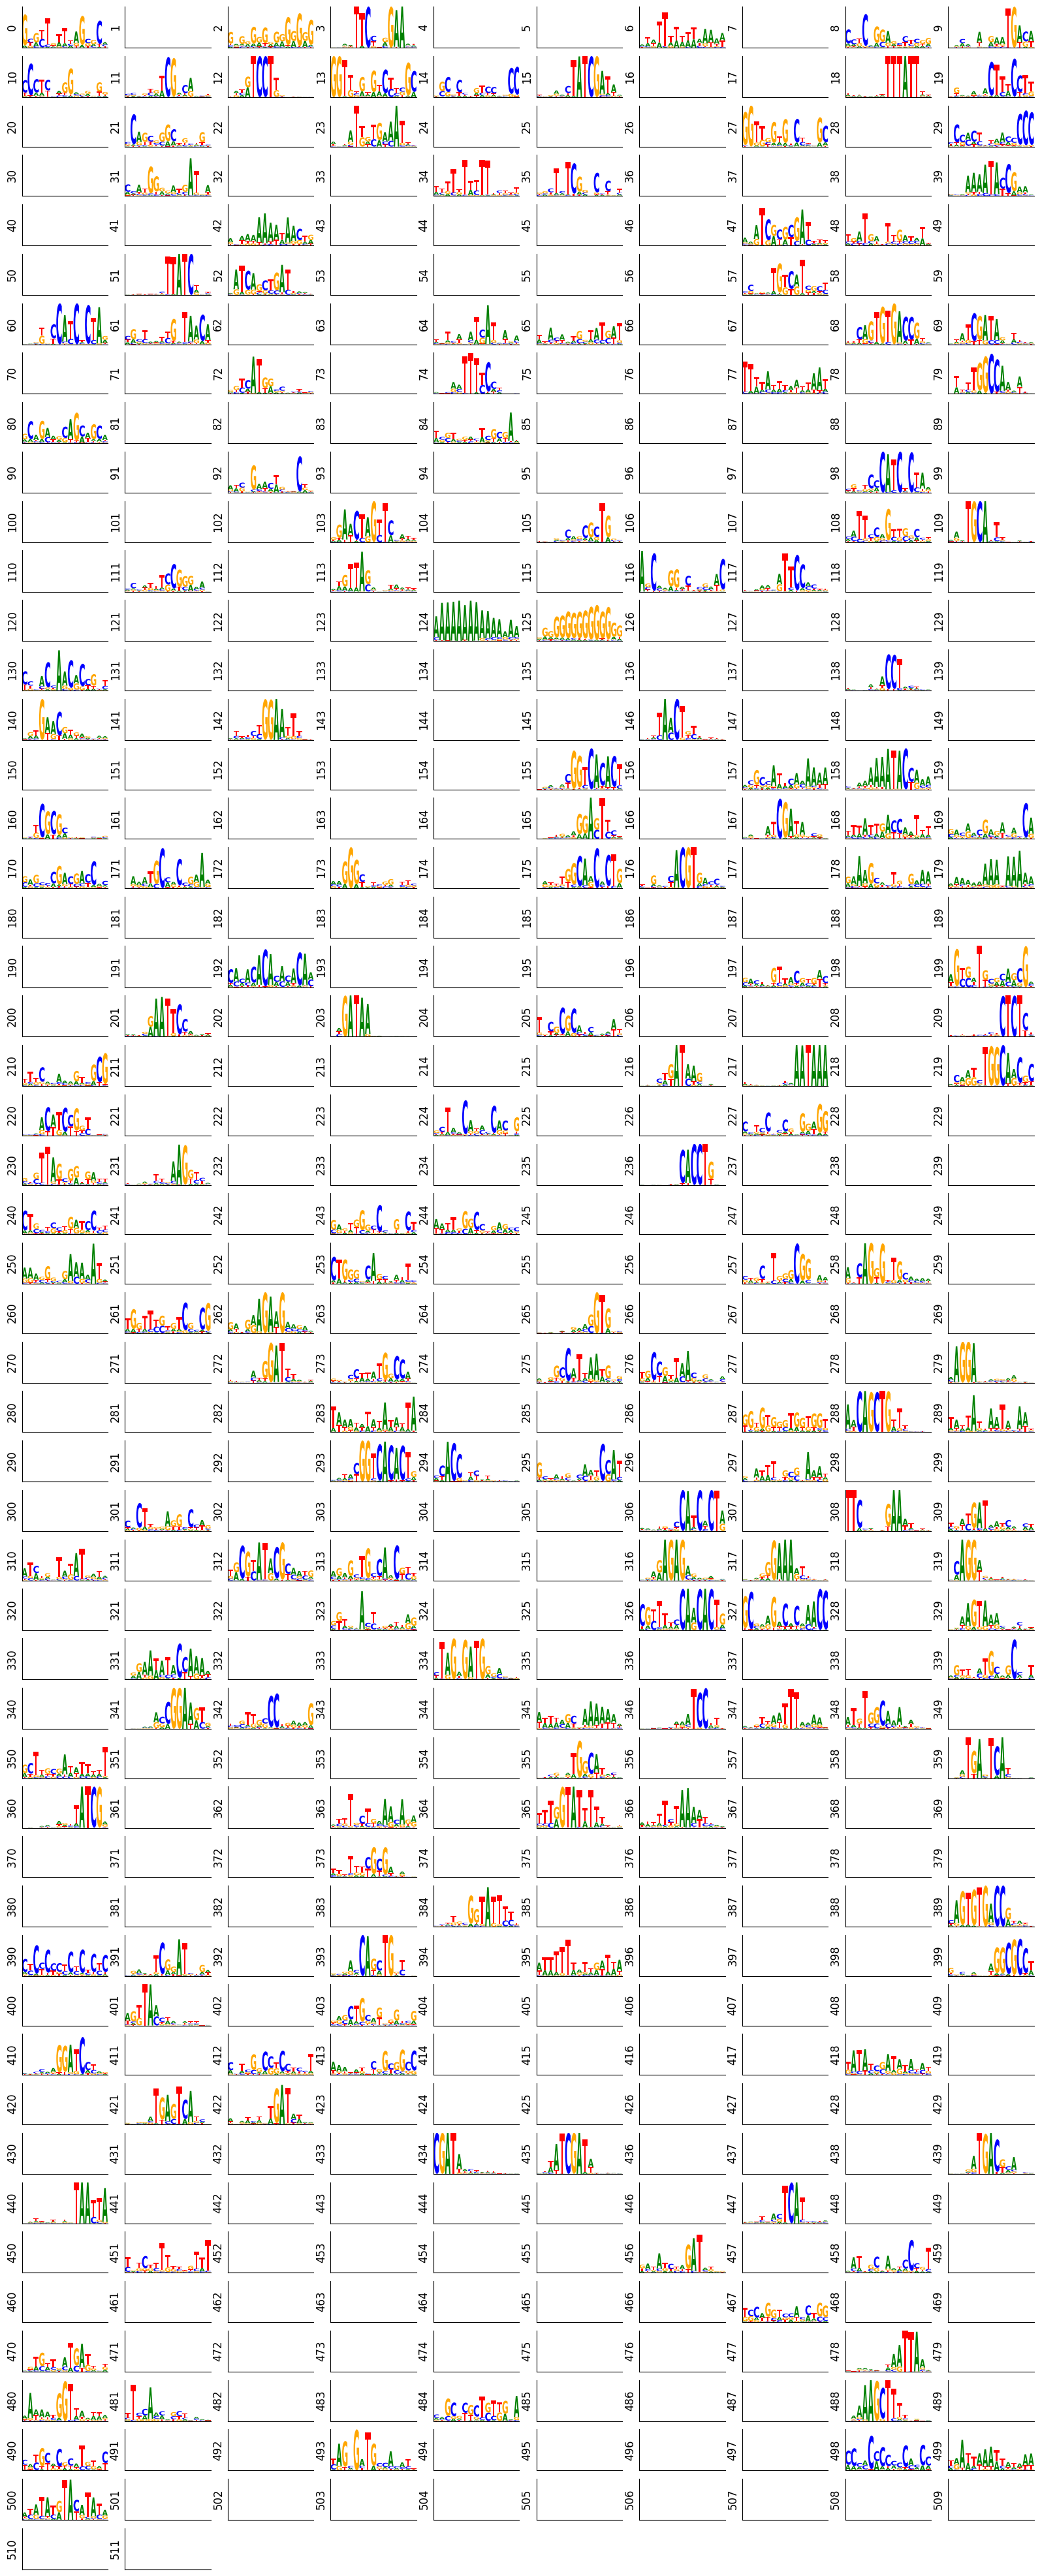

In [14]:
# ==============================================================================
# Interpret filters
# ==============================================================================

filters_path = f"{params_path}/filters"
Path(filters_path).mkdir(parents=True, exist_ok=True)

print("Calculating filter activations...")

layer = 2
threshold = 0.5
window = 20
# intermediate = tf.keras.Model(inputs=model.inputs, outputs=model.layers[layer].output)
# fmap = intermediate.predict(x_test)
# W, counts = utils.activation_pwm(fmap, x_test, threshold=threshold, window=window)
kernel_size = config['conv1_kernel_size']
W, counts = utils.filter_max_align_batch(x_test, model, layer=2, window=kernel_size, threshold=0.5)

W_clipped = utils.clip_filters(W, threshold=0.5, pad=3)
moana.meme_generate(W_clipped, output_file=f"{filters_path}/filters.txt")

# save filter PWMs to an h5 file
with h5py.File(f"{filters_path}/filters.h5", "w") as f:
    dset = f.create_dataset(name="filters", data=W, dtype='float32')

# write jaspar file for RSAT:
output_file = f"{filters_path}/filter_hits.jaspar"

path = Path(output_file)
if path.is_file():
    sh.rm(output_file)

# get the position frequency matrix
pfm = np.array([W[i] * counts[i] for i in range(len(counts))])

# write jaspar file for RSAT:
output_file = f"{filters_path}/filter_hits.jaspar"
utils.write_filters_jaspar(output_file, pfm)

# plot filters
fig = plt.figure(figsize=(20, model.layers[1].get_weights()[0].shape[-1]//10))
W_df = impress.plot_filters(W, fig, num_cols=10, fontsize=12, names=range(len(W)))
fig.savefig(f"{filters_path}/filters.pdf", format='pdf', dpi=200, bbox_inches='tight')

In [ ]:
# # ==============================================================================
# # Interpret filters
# # ==============================================================================

# filters_path = f"{params_path}/filters"
# Path(filters_path).mkdir(parents=True, exist_ok=True)

# print("Calculating filter activations...")

# layer = 2
# threshold = 0.5
# window = 20
# # intermediate = tf.keras.Model(inputs=model.inputs, outputs=model.layers[layer].output)
# # fmap = intermediate.predict(x_test)
# # W, counts = utils.activation_pwm(fmap, x_test, threshold=threshold, window=window)
# kernel_size = config['conv1_kernel_size']
# W, counts = utils.filter_max_align_batch(x_test, model, layer=2, window=kernel_size, threshold=0.5)

# W_clipped = utils.clip_filters(W, threshold=0.5, pad=3)
# moana.meme_generate(W_clipped, output_file=f"{filters_path}/filters.txt")

# # save filter PWMs to an h5 file
# with h5py.File(f"{filters_path}/filters.h5", "w") as f:
#     dset = f.create_dataset(name="filters", data=W, dtype='float32')

# # write jaspar file for RSAT:
# output_file = f"{filters_path}/filter_hits.jaspar"

# path = Path(output_file)
# if path.is_file():
#     sh.rm(output_file)

# # get the position frequency matrix
# pfm = np.array([W[i] * counts[i] for i in range(len(counts))])

# # write jaspar file for RSAT:
# output_file = f"{filters_path}/filter_hits.jaspar"
# utils.write_filters_jaspar(output_file, pfm)

# # plot filters
# fig = plt.figure(figsize=(20, model.layers[1].get_weights()[0].shape[-1]//10))
# W_df = impress.plot_filters(W, fig, num_cols=10, fontsize=12, names=range(len(W)))
# fig.savefig(f"{filters_path}/filters.pdf", format='pdf', dpi=200, bbox_inches='tight')

In [ ]:
# tomtom
# motif_path = f"/home/chandana/projects/hominid/results/deepstarr_peter/filters/filters.txt"

# jaspar_path = '/home/chandana/projects/deepstarr/data/JASPAR2020_CORE_vertebrates_redundant.meme'

# moana.tomtom(
#     motif_path,
#     jaspar_path,
#     output_path=f"{save_path}",
#     tomtom_path="/home/chandana/bin/meme/bin/tomtom"
# )

In [ ]:
def make_directory(dir_name: str):
    Path(dir_name).mkdir(parents=True, exist_ok=True)
    return

def filter_interpretability_pipeline(
    file_prefix,
    config,
    model,
    x_test,
    layer
    fast: bool = False,
    to_h5: bool = True,
    to_jaspar: bool = True,
    run_tomtom: bool = False,
    plot_filters: bool = True,
    jaspar_path: str = "/home/chandana/projects/deepstarr/data/JASPAR2020_CORE_vertebrates_redundant.meme"
    ):
    
    print("Calculating filter activations...")
    
    filters_path = f"{params_path}/filters"
    make_directory(make_directory)
    
    if fast:
        intermediate = tf.keras.Model(inputs=model.inputs, outputs=model.layers[layer].output)
        fmap = intermediate.predict(x_test)
        W, counts = utils.activation_pwm(fmap, x_test)
    else:
        W, counts = utils.filter_max_align_batch(x_test, model, layer=layer)
    
    if run_tomtom:
        W_clipped = utils.clip_filters(W)
        moana.meme_generate(W_clipped, output_file=f"{file_prefix}/filters.txt")
        
        motif_path: str = "/home/chandana/projects/hominid/results/deepstarr_peter/filters/filters.txt"

        moana.tomtom(
            motif_path,
            jaspar_path,
            output_path=f"{save_path}",
            tomtom_path="/home/chandana/bin/meme/bin/tomtom"
        )
    
    if to_h5:
        # save filter PWMs to an h5 file
        with h5py.File(f"{file_prefix}/filters.h5", "w") as f:
            dset = f.create_dataset(name="filters", data=W, dtype='float32')
    
    if to_jaspar:
        # write jaspar file for RSAT:
        output_file = f"{file_prefix}/filter_hits.jaspar"

        path = Path(output_file)
        if path.is_file():
            print("The filter hits jaspar file already exists. Deleting.")
            sh.rm(output_file)

        # get the position frequency matrix
        pfm = np.array([W[i] * counts[i] for i in range(len(counts))])

        # write jaspar file for RSAT:
        utils.write_filters_jaspar(output_file, pfm)
    
    if plot_filters:
        # plot filters
        fig = plt.figure(figsize=(20, model.layers[1].get_weights()[0].shape[-1] // 10))
        W_df = impress.plot_filters(W, fig, num_cols=10, fontsize=12, names=range(len(W)))
        fig.savefig(f"{file_prefix}/filters.pdf", format='pdf', dpi=200, bbox_inches='tight')

    print("Done!")
    return
    